### Adapted from `q1.py`

In [2]:
##Script to read simulation snapshots departure time and location. Assign agent location to building.
##Global imports
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import geopandas
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np

In [3]:
ls

README.md                   scripts/
data/                       snapshot_to_building.ipynb


### Separated start and end functions to return separate dataframes instead of a tuple

In [7]:
sim_snap = pd.read_csv("data/vehicle_data/Simulation_Snapshot/Snapshot_small.csv")

In [181]:
##Read simulation snapshot departure time.
def start_df(sim_snap_df:str,sim_start,sim_end):
    sim_snap_df = sim_snap.groupby('VEHICLE')
    sim_start = pd.DataFrame(sim_snap_df.head(1))
    return sim_start

def end_df(sim_snap_df:str,sim_end):
    sim_snap_df = sim_snap.groupby('VEHICLE')
    sim_end = pd.DataFrame(sim_snap_df.tail(1))
    return sim_end

### Let's use a geojson vehicle snapshot instead of csv

In [18]:
sim_snap_geojson = geopandas.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
def start(sim_snap_df:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_start_gpd = sim_snap_df.head(1)
    return sim_start_gpd

def end(sim_snap_df:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_end_gpd = sim_snap_df.tail(1)
    return sim_end_gpd

### Let's try adding condition of speed = 0 to the `end` function

In [309]:
def end_stopped(sim_snap_df:str,sim_end:str):
    sim_snap_df = sim_snap_geojson[sim_snap_geojson.SPEED  == 0].groupby('VEHICLE')
    sim_end_gpd = sim_snap_df.tail(1)
    return sim_end_gpd

### KNN using building centroids
I think we have to set a seed and use training and test data for this function - although we just want to calculate minimum euclidean distances - let's come back to this.

Regardless, the building centroids will be the dataset upon which we match the vehicle locations.

#### Additionally, 
I am not sure if k-nn is appropriate without conditioning on building types or adding some sort of weights... e.g. a huge building will be further from vehicles but likely has a lot of capacity and daytime population. I think `KNeighborsClassifier` would be most appropriate of the k-nn options in sklearn

In [311]:
sim_end=end_df(sim_snap,'3:00')
centroids=pd.read_csv('data/building_data/Building_Footprints/centroids_clipped.csv')
vehicles_coord=sim_end[['X_COORD','Y_COORD']]
centroids_coord=centroids[['xcoord','ycoord']]

In [ ]:
X_train, X_train,y_test,y_test=train_test_split(X,y,test_size=0.2, train_size=0.7,random_state=0, stratify=y)
knn=KNeighborsClassifier(n_neighbors=1,metric='euclidean',p=2)
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)

In [222]:
neigh = NearestNeighbors(n_neighbors=2)
knn=neigh.fit(centroids_coord)

In [265]:
X = sim_end[['X_COORD','Y_COORD']]
knn_centroids=neigh.kneighbors(X, return_distance=True)
#knn_centroids=pd.DataFrame(knn_centroids[1],knn_centroids[0])
knn_dist=pd.DataFrame(knn_centroids[0])
knn_dist
knn_idx=pd.DataFrame(knn_centroids[1])
knn_centroids=[knn_idx,knn_dist]
knn_centroids

[         0     1
 0      122   493
 1     1164  1695
 2     1104   281
 3       98  1150
 4      122   493
 ...    ...   ...
 1448   705  1468
 1449  2264  1903
 1450   705  1468
 1451    51   620
 1452  1468   310
 
 [1453 rows x 2 columns],                0           1
 0     381.550754  393.770211
 1      91.620571  122.685738
 2      69.709055   70.019465
 3      37.540517   50.268252
 4     468.424436  477.682025
 ...          ...         ...
 1448  152.878803  179.593138
 1449  449.450655  466.024853
 1450  158.130126  174.067599
 1451   63.633621   85.992266
 1452  146.493136  167.859599
 
 [1453 rows x 2 columns]]

In [271]:
knn_centroids=pd.concat([knn_idx, knn_dist], axis=1)
knn_centroids.columns=['idx1','idx2','d1','d2']
knn_centroids

,idx1,idx2,d1,d2
0,122,493,381.550754,393.770211
1,1164,1695,91.620571,122.685738
2,1104,281,69.709055,70.019465
3,98,1150,37.540517,50.268252
4,122,493,468.424436,477.682025
...,...,...,...,...
1448,705,1468,152.878803,179.593138
1449,2264,1903,449.450655,466.024853
1450,705,1468,158.130126,174.067599
1451,51,620,63.633621,85.992266


## Question: 
We want to hold the attributes in the vehicles dataframe that are not used in the knn algorithm and connect them with the output. How can I connect the knn fit with the original dataset?

In [217]:
def knn_map(vehicle_id:int,end_time:str,n_neighbors:str):
    sim_snap_geojson = geopandas.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
    sim_end=end(sim_snap_geojson,end_time)
    
    centroids_coord=centroids[['xcoord','ycoord']]
    X = sim_end[['X_COORD','Y_COORD']]

    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    knn=neigh.fit(centroids_coord)
    
    knn_centroids=neigh.kneighbors(X, return_distance=True)
    
    knn_dist=pd.DataFrame(knn_centroids[0])
    knn_idx=pd.DataFrame(knn_centroids[1])
    knn_centroids=pd.concat([knn_idx, knn_dist], axis=1)
    knn_centroids=[knn_idx['idx',vehicle_id],:]
    
    return knn_centroids

In [ ]:
def count_agents(building_id:int):
    building_counts=knn_centroids['idx1',building_id].count()
    return building_counts

### adapted from `sundar_wb` branch

In [4]:
building_map=geopandas.read_file("data/building_data/Building_Footprints/buildings_clipped.geojson")

In [83]:
## Adding end df as well to see how the building occupancy changes. 
def agent_to_building(sim_start,sim_end,building_map):
    building_map = building_map.to_crs(epsg=26916)
    building_map = building_map.assign(centroid=building_map.centroid)
    
    #START
    sim_start_gdf = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_start_gdf.crs="EPSG:26916"
    
    min_dist = np.empty(len(sim_start_gdf))
    for i, agent in enumerate(sim_start_gdf.geometry):
        min_dist[i] = np.argmin([agent.distance(centroid) for centroid in building_map.centroid])
    sim_start_gdf['building_id'] = min_dist
    agent_count_start = sim_start_gdf.groupby('building_id').count()
    
    #END
    sim_end_gdf = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_end_gdf.crs="EPSG:26916"
    min_dist = np.empty(len(sim_end_gdf))
    for i, agent in enumerate(sim_end_gdf.geometry):
        min_dist[i] = np.argmin([agent.distance(centroid) for centroid in building_map.centroid])
    sim_end_gdf['building_id'] = min_dist
    agent_count_end = sim_end_gdf.groupby('building_id').count()

    
    build_agent_count = building_map.merge(agent_count_start.VEHICLE,right_index=True,left_index=True) 
    build_agent_count_both=build_agent_count.merge(agent_count_end.VEHICLE,right_index=True,left_index=True)
    ##ADD 1 to move building ID??
    return build_agent_count_both

In [111]:
# Generate plots, visualize start and end locations.
def plot_start_end(sim_start:str,sim_end:str,building_agent_count:str):

    building_map = build_agent_count.to_crs(epsg=26916)
    fig,ax = plt.subplots(figsize=(12,12))
    building_map.plot(ax=ax,column="VEHICLE",cmap='hot',vmin=0,vmax=50)
    minx, miny, maxx, maxy = building_map.geometry.total_bounds
    
    sim_start = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_end = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_start.crs="EPSG:26916"
    sim_end.crs="EPSG:26916"

    sim_start.plot(ax=ax, marker='o', color='lime', markersize=1,label='sim_start')
    sim_end.plot(ax=ax, marker='o', color='red', markersize=1,label='sim_end')
    
    ax.set_xlim(minx - 100, maxx + 100)
    ax.set_ylim(miny - 100, maxy + 100)
    
    sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=50))
    fig.colorbar(sm, ax=ax)
    ax.set_facecolor('xkcd:light blue')
    ax.set_title('Chicago Building Set colored by number of mapped occupants, and starting and end locations')
    ax.legend()
    
    plt.show()

In [99]:
sim_start=start(sim_snap_geojson)
sim_end=end(sim_snap_geojson)

In [85]:
build_agent_count_both=agent_to_building(sim_start,sim_end,building_map)

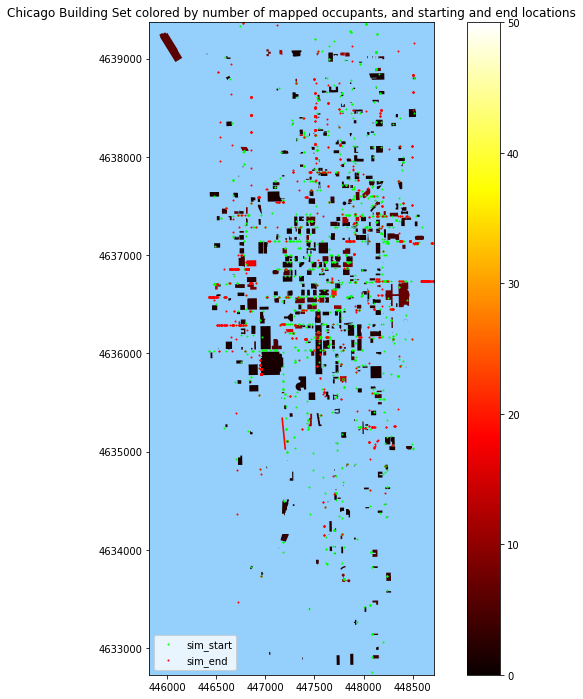

In [112]:
plot_start_end(sim_start,sim_end,build_agent_count_both)

#### TODO: Scale to 25million lines by speeding up and iterating between different sections of the snapshot.
